In [2]:
import torch
import torch.nn  as nn
from torchvision import models
from PIL import Image
from torchvision import transforms

In [3]:
class EmotionModel(nn.Module):
    def __init__(self, num_classes=3):  # Adjust based on your dataset
        super(EmotionModel, self).__init__()
        self.base_model = models.resnet50(pretrained=False)  # Use the same base model
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)  # Match output

    def forward(self, x):
        return self.base_model(x)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

cuda


In [5]:
model = EmotionModel(num_classes=3)  # Ensure num_classes matches your training
state_dict = torch.load("/kaggle/input/pneumonia_model/pytorch/v1.0/1/pneumonia_model.pth")
new_state_dict = {f"base_model.{k}": v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)  # Move model to GPU
model.eval()  # Set to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-cddfcf6092dc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

EmotionModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [6]:
class_names = {
    0: "normal",
    1: "bacterial",
    2: "viral"
}


In [7]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [8]:
image_path = "/kaggle/input/chestxray-feature/chest_xray/train/bacterial/person1000_bacteria_2931.jpeg"
image = Image.open(image_path).convert("RGB")

In [9]:
input_tensor = test_transform(image).unsqueeze(0)

In [10]:
model.to(device)
input_tensor = input_tensor.to(device)

In [11]:
with torch.no_grad():
    output = model(input_tensor)
    # Optionally, get probabilities using softmax
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_idx = torch.argmax(probabilities, dim=1).item()

print("Predicted class index:", predicted_idx)
print("Predicted class:", class_names.get(predicted_idx, "Unknown"))

Predicted class index: 1
Predicted class: bacterial


In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [13]:
test_dataset = ImageFolder(root='/kaggle/input/chestxray-feature/chest_xray/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [14]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        print("-",end="")
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # get the index of the max log-probability
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

----------

In [15]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 33   7 194]
 [  0 220  22]
 [  0  14 134]]


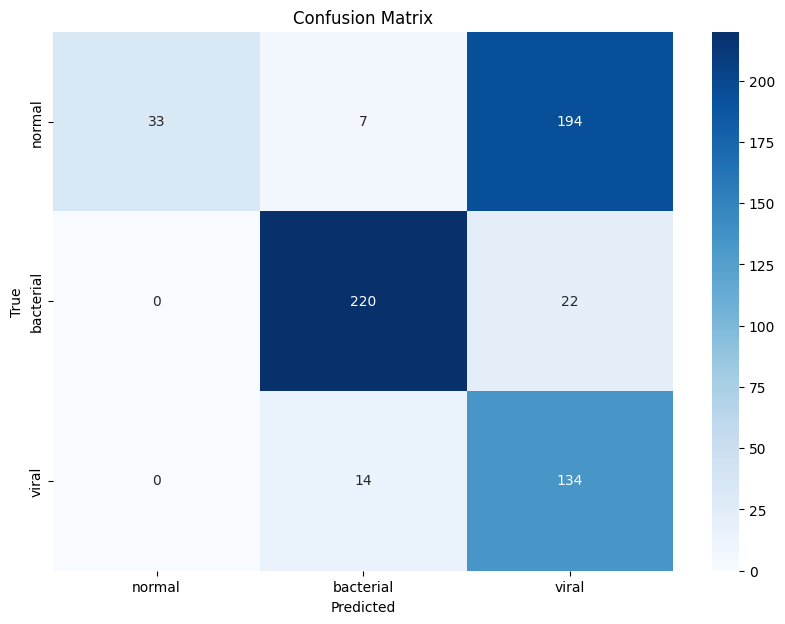

In [16]:
# Example class names dictionary
class_names = {
    0: "normal",
    1: "bacterial",
    2: "viral"
}

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [17]:
model.base_model.fc = nn.Identity()

In [18]:
all_features = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        features = model(inputs)  # Now outputs features instead of class scores
        all_features.append(features.cpu())
        all_labels.extend(labels.numpy())

# Concatenate all features into one tensor and convert to numpy array for PCA.
all_features = torch.cat(all_features, dim=0).numpy()

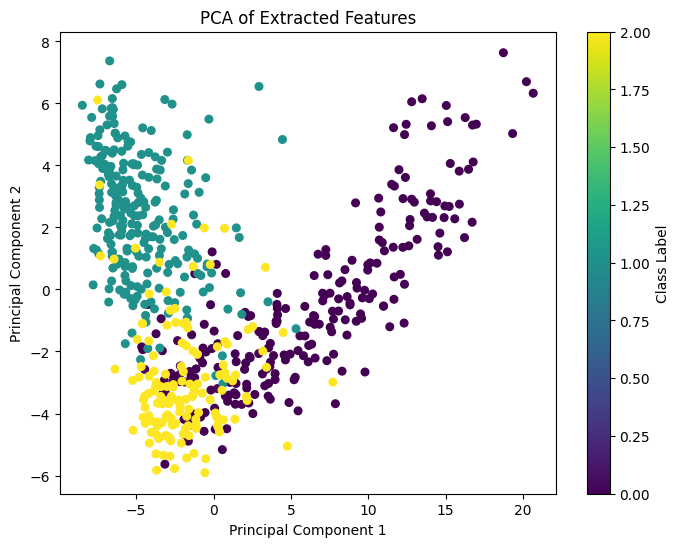

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 components for visualization (or any other number for analysis)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(all_features)

# Plot the PCA results
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=all_labels, cmap='viridis', s=30)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Extracted Features")
plt.colorbar(label="Class Label")
plt.show()


In [20]:
explained_variance = pca.explained_variance_ratio_
print("Explained variance per component:", explained_variance)

# Total variance captured by the selected components
total_variance_captured = explained_variance.sum()
print("Total variance captured:", total_variance_captured)

Explained variance per component: [0.66636354 0.15877166]
Total variance captured: 0.82513523


In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 components for visualization (or any other number for analysis)
pca = PCA(n_components=20)
features_pca = pca.fit_transform(all_features)

explained_variance = pca.explained_variance_ratio_
print("Explained variance per component:", explained_variance)

# Total variance captured by the selected components
total_variance_captured = explained_variance.sum()
print("Total variance captured:", total_variance_captured)

Explained variance per component: [0.6663633  0.15877172 0.07987177 0.01639417 0.01149205 0.00833731
 0.00728597 0.00532408 0.00425568 0.00377319 0.00349357 0.00257474
 0.00201224 0.00187667 0.00175377 0.00161811 0.00135907 0.00110877
 0.00102006 0.00085979]
Total variance captured: 0.979546


In [22]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, input_image, target_layer, class_idx=None):
    """
    Computes Grad-CAM for the given model and input_image.
    
    Args:
      model (nn.Module): The neural network model.
      input_image (torch.Tensor): Preprocessed image tensor with shape [1, 3, H, W].
      target_layer (nn.Module): The convolutional layer to target (e.g., model.base_model.layer4).
      class_idx (int, optional): The class index for which to compute Grad-CAM.
                                 If None, the predicted class is used.
    
    Returns:
      heatmap (np.ndarray): The computed Grad-CAM heatmap.
    """
    # Set model to evaluation mode
    model.eval()
    
    # Placeholders for the feature maps and gradients
    features = None
    gradients = None

    # Define forward hook to capture features
    def forward_hook(module, input, output):
        nonlocal features
        features = output.detach()
    
    # Define backward hook to capture gradients
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()
    
    # Register hooks on the target layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass
    output = model(input_image)
    
    # Choose target class: either provided or the predicted one
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    
    # Zero gradients and backpropagate the score of the target class
    model.zero_grad()
    target_score = output[0, class_idx]
    target_score.backward()
    
    # Pool the gradients across the spatial dimensions (global average pooling)
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # Weight the channels in the feature maps with the pooled gradients
    weighted_features = features.clone()
    for i in range(weighted_features.shape[1]):
        weighted_features[:, i, :, :] *= pooled_gradients[i]
    
    # Generate the heatmap by summing the channels and applying ReLU
    heatmap = torch.sum(weighted_features, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)  # Normalize between 0 and 1
    heatmap = heatmap.cpu().numpy()
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()
    
    return heatmap


In [23]:
image_path = "/kaggle/input/chestxray-feature/chest_xray/train/bacterial/person1000_bacteria_2931.jpeg"  # Replace with your image file
original_image = cv2.imread(image_path)  # For later visualization (BGR format)
original_image = cv2.resize(original_image, (224, 224))

In [24]:
pil_img = Image.open(image_path).convert("RGB")
input_tensor = test_transform(pil_img).unsqueeze(0)

In [25]:
model.to(device)
input_tensor = input_tensor.to(device)

In [26]:
target_layer = model.base_model.layer4

# Compute the Grad-CAM heatmap
heatmap = grad_cam(model, input_tensor, target_layer, class_idx=None)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


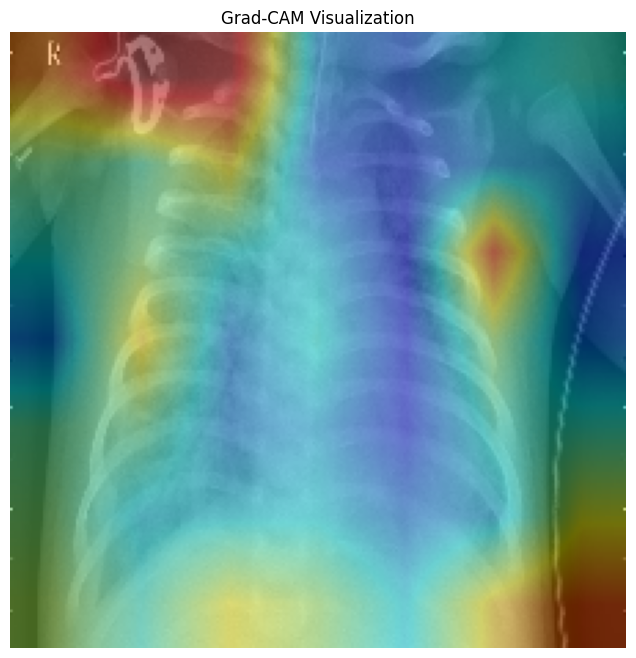

In [27]:
# Resize heatmap to match the image size
heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply a color map (JET) to the heatmap
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap onto the original image with some transparency
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

# Convert to RGB for plotting with matplotlib
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


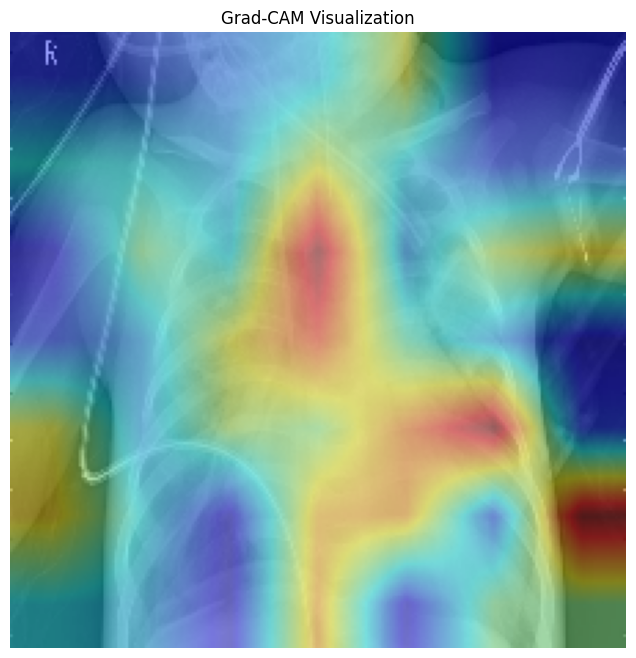

In [28]:
image_path = "/kaggle/input/chestxray-feature/chest_xray/train/bacterial/person1008_bacteria_2939.jpeg"  # Replace with your image file
original_image = cv2.imread(image_path)  # For later visualization (BGR format)
original_image = cv2.resize(original_image, (224, 224))

pil_img = Image.open(image_path).convert("RGB")
input_tensor = test_transform(pil_img).unsqueeze(0)

model.to(device)
input_tensor = input_tensor.to(device)

target_layer = model.base_model.layer4

# Compute the Grad-CAM heatmap
heatmap = grad_cam(model, input_tensor, target_layer, class_idx=None)

# Resize heatmap to match the image size
heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply a color map (JET) to the heatmap
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap onto the original image with some transparency
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

# Convert to RGB for plotting with matplotlib
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


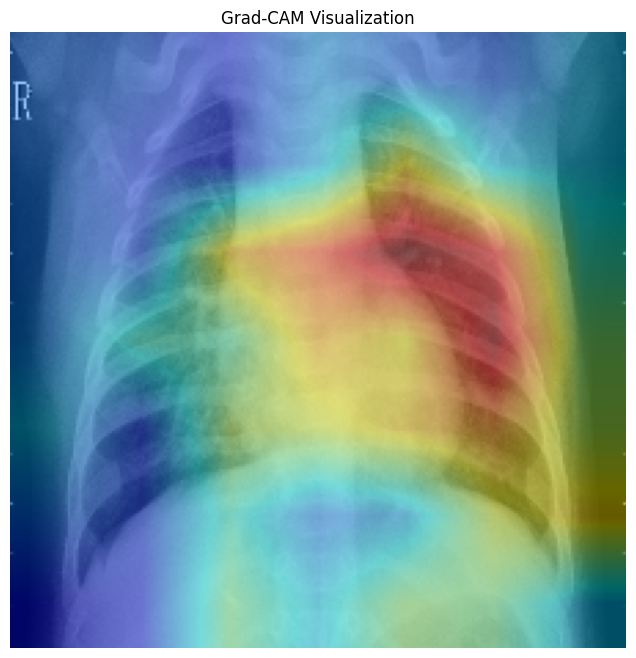

In [29]:
image_path = "/kaggle/input/chestxray-feature/chest_xray/train/viral/person1000_virus_1681.jpeg"  # Replace with your image file
original_image = cv2.imread(image_path)  # For later visualization (BGR format)
original_image = cv2.resize(original_image, (224, 224))

pil_img = Image.open(image_path).convert("RGB")
input_tensor = test_transform(pil_img).unsqueeze(0)

model.to(device)
input_tensor = input_tensor.to(device)

target_layer = model.base_model.layer4

# Compute the Grad-CAM heatmap
heatmap = grad_cam(model, input_tensor, target_layer, class_idx=None)

# Resize heatmap to match the image size
heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply a color map (JET) to the heatmap
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap onto the original image with some transparency
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

# Convert to RGB for plotting with matplotlib
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


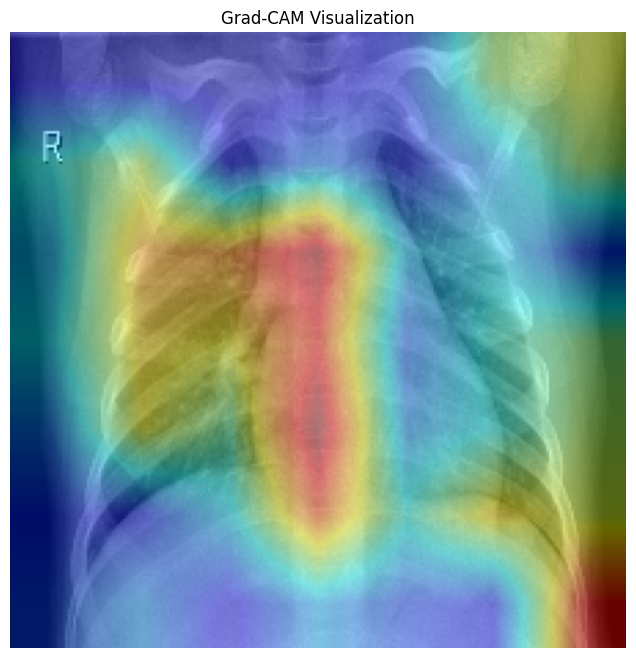

In [30]:
image_path = "/kaggle/input/chestxray-feature/chest_xray/train/NORMAL/IM-0127-0001.jpeg"  # Replace with your image file
original_image = cv2.imread(image_path)  # For later visualization (BGR format)
original_image = cv2.resize(original_image, (224, 224))

pil_img = Image.open(image_path).convert("RGB")
input_tensor = test_transform(pil_img).unsqueeze(0)

model.to(device)
input_tensor = input_tensor.to(device)

target_layer = model.base_model.layer4

# Compute the Grad-CAM heatmap
heatmap = grad_cam(model, input_tensor, target_layer, class_idx=None)

# Resize heatmap to match the image size
heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply a color map (JET) to the heatmap
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap onto the original image with some transparency
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

# Convert to RGB for plotting with matplotlib
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


In [31]:
import torch
import torch.nn.functional as F

def get_feature_maps(model, input_image, target_layer):
    """
    Returns the output feature maps from the target_layer.
    """
    features = None

    def forward_hook(module, input, output):
        nonlocal features
        features = output.detach()

    handle = target_layer.register_forward_hook(forward_hook)
    _ = model(input_image)  # Forward pass
    handle.remove()
    return features  # shape: [1, C, H, W]


In [32]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume 'model' is already in evaluation mode and on the correct device.
# 'input_tensor' is your preprocessed input image with shape [1, 3, H, W]
# 'target_layer' is the layer you want to analyze (e.g., model.base_model.layer4)

# Get feature maps: shape [1, C, H, W]
features = get_feature_maps(model, input_tensor, target_layer)

# Remove batch dimension and reshape: [C, H, W] -> [H*W, C]
features_np = features.squeeze(0).cpu().numpy()  # shape: (C, H, W)
C, H, W = features_np.shape
features_flat = features_np.reshape(C, -1).T  # shape: (H*W, C)

# Apply PCA to get the first principal component
pca = PCA(n_components=1)
pc = pca.fit_transform(features_flat)  # shape: (H*W, 1)
pc_map = pc.reshape(H, W)

# Normalize the component map to [0, 1]
pc_map_norm = (pc_map - np.min(pc_map)) / (np.max(pc_map) - np.min(pc_map))


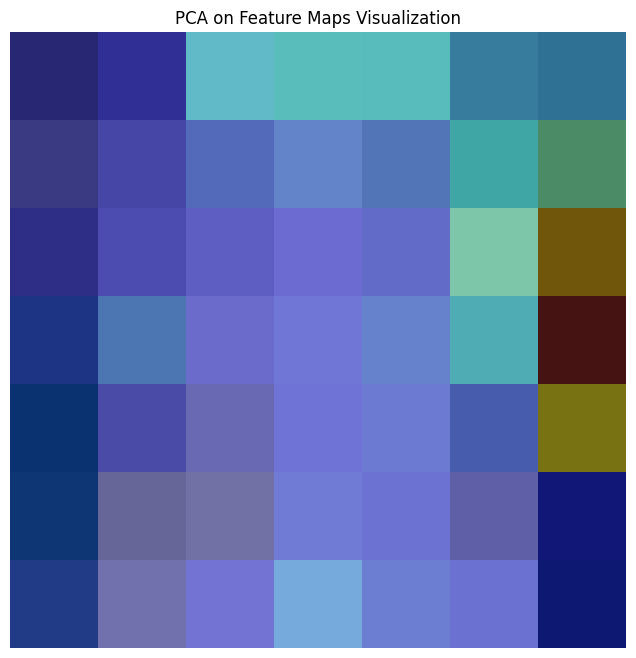

In [33]:
import cv2

# Load the original image (using cv2 or PIL) and resize to (W, H) if needed
orig_img = cv2.imread("/kaggle/input/chestxray-feature/chest_xray/train/bacterial/person1004_bacteria_2935.jpeg")
orig_img = cv2.resize(orig_img, (W, H))

# Convert the normalized PCA map to a heatmap (using a color map)
heatmap = np.uint8(255 * pc_map_norm)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)

# Convert BGR to RGB for matplotlib
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.title("PCA on Feature Maps Visualization")
plt.axis("off")
plt.show()


In [34]:
import numpy as np
from sklearn.decomposition import PCA

# Assume features is a tensor of shape [1, C, H, W]
features_np = features.squeeze(0).cpu().numpy()  # shape: (C, H, W)
C, H, W = features_np.shape

# Reshape to (H*W, C) to apply PCA on the channel dimension
features_flat = features_np.reshape(C, -1).T  # shape: (H*W, C)

# Reduce channels from C to 20
pca = PCA(n_components=20)
features_reduced = pca.fit_transform(features_flat)  # shape: (H*W, 20)

# Reshape back to (20, H, W)
features_reduced = features_reduced.T.reshape(20, H, W)


In [35]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA

def grad_cam_pca(model, input_image, target_layer, n_components=20, class_idx=None):
    """
    Computes a Grad-CAM style heatmap using PCA to reduce feature maps and gradients to n_components channels.
    
    Args:
      model (nn.Module): The neural network model.
      input_image (torch.Tensor): Preprocessed image tensor with shape [1, 3, H, W].
      target_layer (nn.Module): The convolutional layer to target (e.g., model.base_model.layer4).
      n_components (int): Number of PCA components (channels) to keep.
      class_idx (int, optional): The class index for which to compute Grad-CAM.
                                 If None, the predicted class is used.
    
    Returns:
      heatmap (np.ndarray): The computed Grad-CAM heatmap.
    """
    model.eval()
    features = None
    gradients = None

    # Hook functions to capture the output features and gradients.
    def forward_hook(module, input, output):
        nonlocal features
        features = output.detach()  # shape: [1, C, H, W]
    
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()  # shape: [1, C, H, W]
    
    # Register hooks on the target layer.
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass.
    output = model(input_image)
    
    # Determine target class.
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    
    # Backward pass: Compute gradients for the target class.
    model.zero_grad()
    target_score = output[0, class_idx]
    target_score.backward()
    
    # ------------------------------
    # PCA on the feature maps.
    # ------------------------------
    # features: [1, C, H, W] -> [C, H, W]
    features_np = features.squeeze(0).cpu().numpy()  # shape: (C, H, W)
    C, H, W = features_np.shape
    
    # Reshape to (H*W, C) so that each spatial location is a sample.
    features_flat = features_np.reshape(C, -1).T  # shape: (H*W, C)
    
    # Apply PCA to reduce channels from C to n_components.
    pca = PCA(n_components=n_components)
    features_reduced_np = pca.fit_transform(features_flat)  # shape: (H*W, n_components)
    # Reshape back to (n_components, H, W)
    features_reduced_np = features_reduced_np.T.reshape(n_components, H, W)
    # Convert back to torch tensor.
    features_reduced = torch.tensor(features_reduced_np, device=input_image.device, dtype=features.dtype)
    
    # ------------------------------
    # PCA on the gradients.
    # ------------------------------
    # Similarly, process gradients from the same layer.
    gradients_np = gradients.squeeze(0).cpu().numpy()  # shape: (C, H, W)
    gradients_flat = gradients_np.reshape(C, -1).T  # shape: (H*W, C)
    # Project gradients onto the same PCA components.
    # pca.components_ has shape (n_components, C), so we do:
    reduced_gradients_np = np.dot(gradients_flat, pca.components_.T)  # shape: (H*W, n_components)
    reduced_gradients_np = reduced_gradients_np.T.reshape(n_components, H, W)
    reduced_gradients = torch.tensor(reduced_gradients_np, device=input_image.device, dtype=gradients.dtype)
    
    # ------------------------------
    # Compute weights for the reduced channels.
    # ------------------------------
    # Global average pooling over spatial dims on the reduced gradients.
    pooled_gradients = torch.mean(reduced_gradients, dim=[1, 2])  # shape: (n_components,)
    
    # Weight the PCA-reduced feature maps with these pooled gradients.
    weighted_features = features_reduced.clone()
    for i in range(n_components):
        weighted_features[i, :, :] *= pooled_gradients[i]
    
    # Sum along the channel dimension to form a heatmap.
    heatmap = torch.sum(weighted_features, dim=0)  # shape: (H, W)
    heatmap = F.relu(heatmap)
    if torch.max(heatmap) != 0:
        heatmap /= torch.max(heatmap)
    
    heatmap_np = heatmap.cpu().numpy()
    
    # Remove the hooks.
    forward_handle.remove()
    backward_handle.remove()
    
    return heatmap_np


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


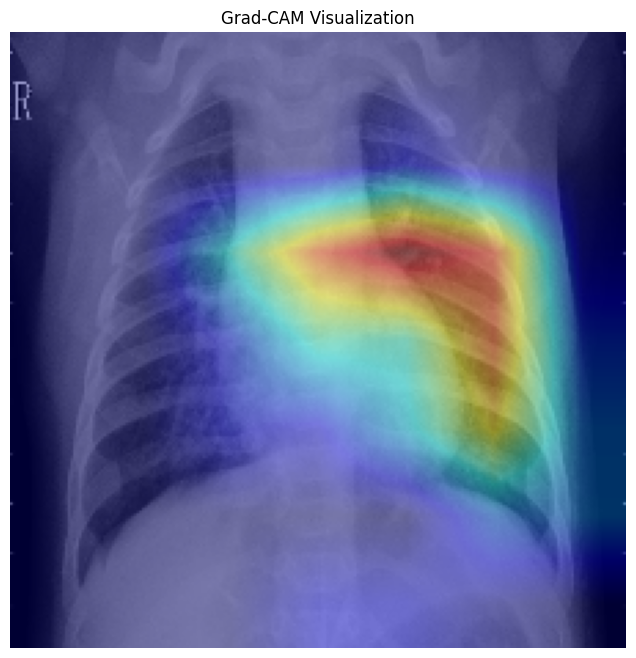

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


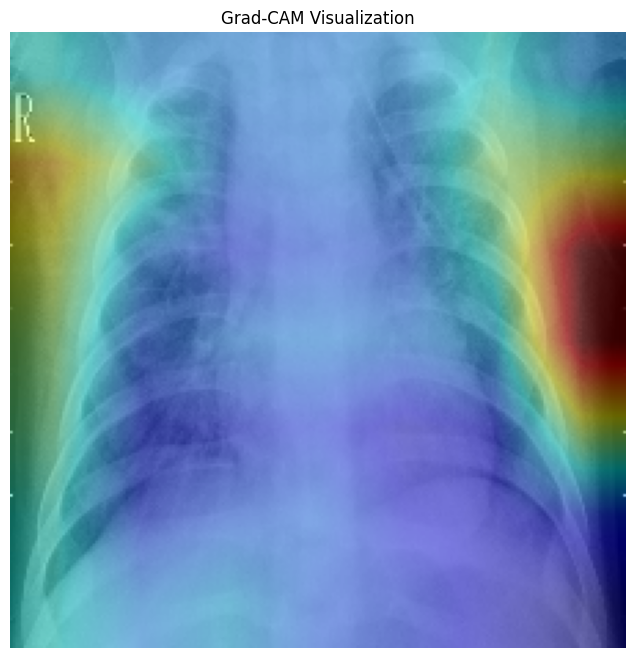

In [36]:
image_path = "/kaggle/input/chestxray-feature/chest_xray/train/viral/person1000_virus_1681.jpeg"  # Replace with your image file
original_image = cv2.imread(image_path)  # For later visualization (BGR format)
original_image = cv2.resize(original_image, (224, 224))

pil_img = Image.open(image_path).convert("RGB")
input_tensor = test_transform(pil_img).unsqueeze(0)

model.to(device)
input_tensor = input_tensor.to(device)

target_layer = model.base_model.layer4

# Compute the Grad-CAM heatmap
heatmap = grad_cam_pca(model, input_tensor, target_layer, 15,class_idx=None)

# Resize heatmap to match the image size
heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply a color map (JET) to the heatmap
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap onto the original image with some transparency
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

# Convert to RGB for plotting with matplotlib
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

image_path = "/kaggle/input/chestxray-feature/chest_xray/train/viral/person1003_virus_1685.jpeg"  # Replace with your image file
original_image = cv2.imread(image_path)  # For later visualization (BGR format)
original_image = cv2.resize(original_image, (224, 224))

pil_img = Image.open(image_path).convert("RGB")
input_tensor = test_transform(pil_img).unsqueeze(0)

model.to(device)
input_tensor = input_tensor.to(device)

target_layer = model.base_model.layer4

# Compute the Grad-CAM heatmap
heatmap = grad_cam(model, input_tensor, target_layer, class_idx=None)

# Resize heatmap to match the image size
heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply a color map (JET) to the heatmap
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose the heatmap onto the original image with some transparency
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

# Convert to RGB for plotting with matplotlib
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


In [37]:
import time
import torch

# Ensure your model and input tensor are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_tensor = input_tensor.to(device)

# ----------------------
# 1. Full Model Inference
# ----------------------
if torch.cuda.is_available():
    torch.cuda.synchronize()  # Ensure all GPU ops finish
start_time = time.time()

# Forward pass through the full model (standard classification)
output_full = model(input_tensor)

if torch.cuda.is_available():
    torch.cuda.synchronize()  # Wait for GPU operations to finish
full_inference_time = time.time() - start_time
print("Full model inference time: {:.4f} seconds".format(full_inference_time))

# ----------------------
# 2. Reduced Feature Model Inference
#    (using PCA-based Grad-CAM pipeline as a proxy for reduced feature computation)
# ----------------------
# Assume target_layer is the layer you want to analyze (e.g., model.base_model.layer4)
if torch.cuda.is_available():
    torch.cuda.synchronize()
start_time = time.time()

# Using the custom grad_cam_pca function that applies PCA to reduce the features
heatmap = grad_cam_pca(model, input_tensor, target_layer, n_components=10, class_idx=None)

if torch.cuda.is_available():
    torch.cuda.synchronize()
reduced_inference_time = time.time() - start_time
print("Reduced feature model inference time: {:.4f} seconds".format(reduced_inference_time))


Full model inference time: 0.0096 seconds
Reduced feature model inference time: 0.0380 seconds


In [38]:
test_dataset = ImageFolder(root='/kaggle/input/chestxray-feature/chest_xray/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [39]:
print(device)

cuda


In [40]:
import torch.nn as nn

# This creates a feature extractor using all layers except the final classification layer.
feature_extractor = nn.Sequential(*list(model.base_model.children())[:-1])


In [41]:
train_dataset = ImageFolder(root='/kaggle/input/chestxray-feature/chest_xray/train', transform=test_transform)
train_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [42]:
model.eval()
feature_extractor.eval()

all_train_features = []
all_train_labels = []
i=0
# Loop over your training data to extract features.
for inputs, labels in train_loader:
    inputs = inputs.to(device)
    i+=1
    print("-",end="")
    if(i%100==0):
        print(i)
    with torch.no_grad():
        # Extract features from the feature extractor (e.g., all layers up to the final FC).
        features = feature_extractor(inputs)  # Expected shape: [batch, D, 1, 1]
        features = features.view(features.size(0), -1)  # Flatten to shape: [batch, D]
    all_train_features.append(features.cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())

# Concatenate features from all batches.
all_train_features = np.concatenate(all_train_features, axis=0)  # Shape: (num_train_samples, D)

----------

In [43]:
from sklearn.decomposition import PCA

# Create a PCA object to reduce features to 20 dimensions.
pca_reducer = PCA(n_components=20)

# Fit PCA on the training features.
pca_reducer.fit(all_train_features)

# Optionally, check the explained variance:
explained_variance = pca_reducer.explained_variance_ratio_
print("Explained variance per component:", explained_variance)
print("Total variance captured:", explained_variance.sum())


Explained variance per component: [0.6663637  0.15877153 0.07987177 0.01639417 0.01149207 0.00833731
 0.00728597 0.00532408 0.00425568 0.00377319 0.00349357 0.00257474
 0.00201224 0.00187666 0.00175377 0.00161811 0.00135907 0.00110877
 0.00102006 0.00085979]
Total variance captured: 0.97954625


In [44]:
import joblib
import os

# Ensure the working directory is set
save_path = "/kaggle/working/pca_reducer.pkl"

# Save the fitted PCA reducer
joblib.dump(pca_reducer, save_path)
print(f"PCA model saved at {save_path}")

# Verify the file exists
print(os.listdir("/kaggle/working/"))



PCA model saved at /kaggle/working/pca_reducer.pkl
['pca_reducer.pkl', '.virtual_documents']


In [50]:
import torch
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is in evaluation mode
model.to(device)
model.eval()
feature_extractor.to(device)
feature_extractor.eval()

# Extract features from training data
train_features = []
train_labels = []

for inputs, labels in train_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        features = feature_extractor(inputs)  # Extract CNN features
        features = features.view(features.size(0), -1)  # Flatten features
    train_features.append(features.cpu().numpy())
    train_labels.extend(labels.cpu().numpy())

# Convert list to numpy array
train_features = np.concatenate(train_features, axis=0)
train_labels = np.array(train_labels)

# Apply PCA for dimensionality reduction
pca_reducer = PCA(n_components=20)  # Reduce to 20 features
train_features_pca = pca_reducer.fit_transform(train_features)

# Split dataset for validation
X_train, X_val, y_train, y_val = train_test_split(train_features_pca, train_labels, test_size=0.2, random_state=42)

### Train SVM Classifier
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)

### Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on validation set
svm_preds = svm_classifier.predict(X_val)
rf_preds = rf_classifier.predict(X_val)

# Compute accuracy
svm_accuracy = accuracy_score(y_val, svm_preds)
rf_accuracy = accuracy_score(y_val, rf_preds)

print(f"SVM Validation Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Validation Accuracy: {rf_accuracy:.4f}")

# Save PCA, SVM, and RF models
joblib.dump(pca_reducer, "/kaggle/working/pca_reducer.pkl")
joblib.dump(svm_classifier, "/kaggle/working/svm_classifier.pkl")
joblib.dump(rf_classifier, "/kaggle/working/rf_classifier.pkl")

print("PCA, SVM, and Random Forest models saved successfully!")


SVM Validation Accuracy: 0.9200
Random Forest Validation Accuracy: 0.9280
PCA, SVM, and Random Forest models saved successfully!


In [51]:
import time

# Load saved models
pca_reducer = joblib.load("/kaggle/working/pca_reducer.pkl")
svm_classifier = joblib.load("/kaggle/working/svm_classifier.pkl")

svm_start_time = time.time()
all_features = []
all_true_svm = []

# Extract features from test data
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        features = feature_extractor(inputs)
        features = features.view(features.size(0), -1)  # Flatten features
    all_features.append(features.cpu().numpy())
    all_true_svm.extend(labels.cpu().numpy())

# Convert to numpy arrays
features_test = np.concatenate(all_features, axis=0)

# Apply PCA transformation
features_test_pca = pca_reducer.transform(features_test)

# Predict using the SVM model
svm_preds = svm_classifier.predict(features_test_pca)

# Calculate accuracy
svm_accuracy = accuracy_score(all_true_svm, svm_preds)
svm_time = time.time() - svm_start_time

print(f"SVM with PCA Accuracy: {svm_accuracy:.4f}")
print(f"SVM Inference Time: {svm_time:.4f} sec")


SVM with PCA Accuracy: 0.9199
SVM Inference Time: 5.2359 sec


In [52]:
import time
import torch
import numpy as np
from sklearn.metrics import accuracy_score
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load PCA and SVM models
pca_reducer = joblib.load("/kaggle/working/pca_reducer.pkl")
svm_classifier = joblib.load("/kaggle/working/svm_classifier.pkl")

# Ensure model is in evaluation mode
model.to(device)
model.eval()
feature_extractor.to(device)
feature_extractor.eval()

# Containers for test predictions and true labels
all_test_features = []
all_true_test = []

# Start testing
svm_start_time = time.time()

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        features = feature_extractor(inputs)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten feature maps
    all_test_features.append(features.cpu().numpy())
    all_true_test.extend(labels.cpu().numpy())

# Convert test features to numpy array
features_test = np.concatenate(all_test_features, axis=0)

# Apply PCA transformation
features_test_pca = pca_reducer.transform(features_test)

# Predict using SVM
svm_preds = svm_classifier.predict(features_test_pca)

# Compute accuracy
svm_test_accuracy = accuracy_score(all_true_test, svm_preds)
svm_time = time.time() - svm_start_time

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"SVM Inference Time: {svm_time:.4f} sec")


SVM Test Accuracy: 0.9199
SVM Inference Time: 4.9772 sec


In [53]:
import time
import torch
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved PCA and SVM models
pca_reducer = joblib.load("/kaggle/working/pca_reducer.pkl")
svm_classifier = joblib.load("/kaggle/working/svm_classifier.pkl")

# Ensure the feature extractor model is in evaluation mode
model.to(device)
model.eval()
feature_extractor.to(device)
feature_extractor.eval()

# Containers for test predictions and true labels
all_test_features = []
all_true_test = []

# Start the SVM evaluation process
svm_start_time = time.time()

# Extract features from the test dataset
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        features = feature_extractor(inputs)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten feature maps
    all_test_features.append(features.cpu().numpy())
    all_true_test.extend(labels.cpu().numpy())

# Convert list of feature tensors to a NumPy array
features_test = np.concatenate(all_test_features, axis=0)

# Apply PCA transformation to reduce dimensionality
features_test_pca = pca_reducer.transform(features_test)

# Predict using the trained SVM classifier
svm_preds = svm_classifier.predict(features_test_pca)

# Compute overall accuracy
svm_test_accuracy = accuracy_score(all_true_test, svm_preds)
svm_time = time.time() - svm_start_time

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"SVM Inference Time: {svm_time:.4f} sec")

# Generate a classification report (Precision, Recall, F1-score)
class_names = ["Normal", "Bacterial", "Viral"]
print("\nClassification Report:")
print(classification_report(all_true_test, svm_preds, target_names=class_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_test, svm_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Compute Sensitivity (Recall) and Specificity for each class
sensitivity_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Recall = TP / (TP + FN)
specificity_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)  # Specificity = TN / (TN + FP)

# Print Sensitivity (Recall) and Specificity for each class
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"Sensitivity (Recall): {sensitivity_per_class[i]:.4f}")
    print(f"Specificity: {specificity_per_class[i]:.4f}")


SVM Test Accuracy: 0.9199
SVM Inference Time: 5.3922 sec

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       234
   Bacterial       0.93      0.96      0.95       242
       Viral       0.86      0.84      0.85       148

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624


Confusion Matrix:
[[217   3  14]
 [  2 233   7]
 [  9  15 124]]

Class: Normal
Sensitivity (Recall): 0.9274
Specificity: 0.9518

Class: Bacterial
Sensitivity (Recall): 0.9628
Specificity: 0.9283

Class: Viral
Sensitivity (Recall): 0.8378
Specificity: 0.8552


In [54]:
import time
import torch
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier  # Import RF

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved PCA model and classifiers (SVM & Random Forest)
pca_reducer = joblib.load("/kaggle/working/pca_reducer.pkl")
svm_classifier = joblib.load("/kaggle/working/svm_classifier.pkl")
rf_classifier = joblib.load("/kaggle/working/rf_classifier.pkl")  # Load trained RF model

# Ensure the feature extractor model is in evaluation mode
model.to(device)
model.eval()
feature_extractor.to(device)
feature_extractor.eval()

# Containers for test predictions and true labels
all_test_features = []
all_true_test = []

# Start feature extraction
start_time = time.time()

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    with torch.no_grad():
        features = feature_extractor(inputs)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten feature maps
    all_test_features.append(features.cpu().numpy())
    all_true_test.extend(labels.cpu().numpy())

# Convert extracted features to NumPy array
features_test = np.concatenate(all_test_features, axis=0)

# Apply PCA transformation
features_test_pca = pca_reducer.transform(features_test)

# ========== PCA + SVM ========== #
svm_start_time = time.time()
svm_preds = svm_classifier.predict(features_test_pca)
svm_time = time.time() - svm_start_time

# ========== PCA + Random Forest ========== #
rf_start_time = time.time()
rf_preds = rf_classifier.predict(features_test_pca)
rf_time = time.time() - rf_start_time

# ========== Compute Accuracy ========== #
svm_test_accuracy = accuracy_score(all_true_test, svm_preds)
rf_test_accuracy = accuracy_score(all_true_test, rf_preds)

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"SVM Inference Time: {svm_time:.4f} sec")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")
print(f"Random Forest Inference Time: {rf_time:.4f} sec")

# Class names
class_names = ["Normal", "Bacterial", "Viral"]

# ========== Classification Report for SVM ========== #
print("\n=== SVM Classification Report ===")
print(classification_report(all_true_test, svm_preds, target_names=class_names))

# ========== Classification Report for RF ========== #
print("\n=== Random Forest Classification Report ===")
print(classification_report(all_true_test, rf_preds, target_names=class_names))

# ========== Confusion Matrices ========== #
conf_matrix_svm = confusion_matrix(all_true_test, svm_preds)
conf_matrix_rf = confusion_matrix(all_true_test, rf_preds)

print("\n=== SVM Confusion Matrix ===")
print(conf_matrix_svm)

print("\n=== Random Forest Confusion Matrix ===")
print(conf_matrix_rf)

# ========== Compute Sensitivity (Recall) & Specificity for SVM ========== #
sensitivity_svm = np.diag(conf_matrix_svm) / np.sum(conf_matrix_svm, axis=1)
specificity_svm = np.diag(conf_matrix_svm) / np.sum(conf_matrix_svm, axis=0)

# ========== Compute Sensitivity (Recall) & Specificity for RF ========== #
sensitivity_rf = np.diag(conf_matrix_rf) / np.sum(conf_matrix_rf, axis=1)
specificity_rf = np.diag(conf_matrix_rf) / np.sum(conf_matrix_rf, axis=0)

# Print Sensitivity & Specificity for SVM
print("\n=== SVM Sensitivity & Specificity ===")
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Sensitivity (Recall): {sensitivity_svm[i]:.4f}")
    print(f"Specificity: {specificity_svm[i]:.4f}")

# Print Sensitivity & Specificity for Random Forest
print("\n=== Random Forest Sensitivity & Specificity ===")
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Sensitivity (Recall): {sensitivity_rf[i]:.4f}")
    print(f"Specificity: {specificity_rf[i]:.4f}")


SVM Test Accuracy: 0.9199
SVM Inference Time: 0.0047 sec
Random Forest Test Accuracy: 0.9856
Random Forest Inference Time: 0.0226 sec

=== SVM Classification Report ===
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       234
   Bacterial       0.93      0.96      0.95       242
       Viral       0.86      0.84      0.85       148

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       234
   Bacterial       0.99      1.00      0.99       242
       Viral       0.99      0.96      0.97       148

    accuracy                           0.99       624
   macro avg       0.99      0.98      0.98       624
weighted avg       0.99      0.99      0.99       624


=== SVM Confusion Matri